# Topic modelling for Dreamachine dataset

Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 16/09/2025\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



### imports and global setup

In [7]:
# %%capture

import torch
import os
import numpy as np
import nltk
import sys
import pandas as pd
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
from bertopic.representation import KeyBERTInspired, LlamaCPP
import datamapplot
import random
from sklearn.metrics.pairwise import cosine_similarity



# Global random seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): #will be false on mac but true with gpus
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Environment setup
os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')

# Add project root to path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)

# Import project modules
from src.preprocessor import split_sentences
from src.utils import get_params_grid, calculate_coherence
from src.model import setup_model, setup_umap, setup_hdbscan
from configs.dreamachine2 import config


dataset = "DREAMACHINE"
condition = "HS"

print(f"Current working directory: {os.getcwd()}")
BOX_DIR = os.path.join(os.path.expanduser("~"), "Library", "CloudStorage", "Box-Box", "TMDATA")
print(f"Retrieving data from BOX, locally stored at: {BOX_DIR}")
DATA_DIR = os.path.join(BOX_DIR, dataset)
print(f"Data directory: {DATA_DIR}")


Current working directory: /Users/rb666/Projects/MOSAIC/scripts
Retrieving data from BOX, locally stored at: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA
Data directory: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE


[nltk_data] Downloading package stopwords to /Users/rb666/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Define parameters for current run


In [8]:

sentences = True
random_seed = SEED # uses the global seed 

# Outlier reduction settings
reduce_outliers = False
outlier_strategy = 'embeddings' 
outlier_threshold = 0.7


### Load and preprocess data


In [9]:

reports_path = os.path.join(DATA_DIR, f"{condition}_reflections_APIcleaned.csv")
print("Using data from:", reports_path)

results_dir = os.path.join(project_root, "RESULTS")
results_filename = f"GS_results_{condition}_{'sentences' if sentences else ''}.csv"
results_path = os.path.join(results_dir, results_filename)

print("Loading results from:", results_path)

# load data and divide into sentences if needed
df_reports = pd.read_csv(reports_path)['cleaned_reflection'].dropna().reset_index(drop=True)
df_reports


Using data from: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE/HS_reflections_APIcleaned.csv
Loading results from: /Users/rb666/Projects/MOSAIC/RESULTS/GS_results_HS_sentences.csv


0      Intense chaos. And then my mind checked out an...
1                                            Good stuff.
2      A pattern of red and white lights that flashed...
3      I went back to many hard and mostly beautiful ...
4                                                 Hello.
                             ...                        
328    Changing temperature of my body with the light...
329                                 Pleasure & intrigue.
330                            Travelling through space.
331    I thought a lot about Rand's journey into Rhui...
332    The visual here doesn't look anything like wha...
Name: cleaned_reflection, Length: 333, dtype: object

### Pre-processing


In [10]:
if sentences:
    df_reports = split_sentences(df_reports)[0]

print(f"\nSuccessfully loaded and processed {len(df_reports)} sentences.")


Successfully loaded and processed 736 sentences.


In [11]:
min_words = 2 #threshold for minimum words in a sentence

#print all sentences that contain only min_words word
for i, sentence in enumerate(df_reports):
    if len(sentence.split()) < min_words:
        print(sentence)

#print the amount of sentences that have less than min_words words
short_sentences = [sentence for sentence in df_reports if len(sentence.split()) < min_words]
print(f"\nThere are {len(short_sentences)} sentences with less than {min_words} words.\n")

# Remove sentences with less than 2 words
df_reports = [sentence for sentence in df_reports if len(sentence.split()) >= min_words]
print(f"After removing short sentences, {len(df_reports)} sentences remain.")


Hello.
Devtest.
Confusion.
Vast.
Immense.
Tessellations.
Hexagons.
Joy.
Starfields.
devtest
l
it
Beautiful!
Thanks!
Euphoria
Unease
Bizarre.
Everything.
Pareidolia.
Soothed.
Tired.
Joy.
Calm
Warm
h
cakm
Anxiety.
l8
Vertigo.
Peace.
Peace.
Sunlight.
True.

There are 33 sentences with less than 2 words.

After removing short sentences, 703 sentences remain.


In [12]:
#check if there are any duplicate sentences (lists) and remove them
duplicates = [sentence for sentence in df_reports if df_reports.count(sentence) > 1]
df_reports = [sentence for sentence in df_reports if sentence not in duplicates]
print(f"After removing duplicates, {len(df_reports)} sentences remain.\n")

After removing duplicates, 697 sentences remain.



### Setup models (sentence transformer and countvectorizer) and generate embeddings

In [13]:
# Models setup (from configs)
print("Setting up models and generating embeddings...")

embedding_model = SentenceTransformer(config.transformer_model)
print("Using embedding model:", config.transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)

vectorizer_model = CountVectorizer(
    ngram_range=config.ngram_range, 
    stop_words=list(config.extended_stop_words),
    max_df=config.max_df,
    min_df=config.min_df
)

print("Embeddings and vectorizer ready.")

Setting up models and generating embeddings...
Using embedding model: Qwen/Qwen3-Embedding-0.6B


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Embeddings and vectorizer ready.


### Setup representation model (before LLM)

In [14]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "MMR": mmr,
}

### Train BERTopic model 

In [15]:
### Chose either to load best params from grid search or use defaults tailored ones from the config file
# #  Load best params from grid search
# results_GS = pd.read_csv(results_path)
# chosen_params = results_GS.iloc[0]
# print("Best parameters loaded from grid search:")
# print(chosen_params)


# Load default parameters directly from the config
print(f"Loading default parameters for condition: {condition}")
chosen_params = config.get_default_params(condition)

# Print as a Series for nice formatting, similar to the old output
print("Default parameters loaded:")
print(pd.Series(chosen_params))

Loading default parameters for condition: HS
Default parameters loaded:
n_neighbors         15.0
n_components        10.0
min_dist             0.0
min_cluster_size    10.0
min_samples          5.0
top_n_words         15.0
dtype: float64


In [16]:


# --- Setup UMAP and HDBSCAN models ---
umap_model = setup_umap(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=int(chosen_params['n_components']),
    min_dist=float(chosen_params['min_dist']),
    random_seed=random_seed
)


hdbscan_model = setup_hdbscan(
    min_cluster_size=int(chosen_params['min_cluster_size']),
    min_samples=int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
)

# Initialise and fit the main Topic model
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words= 15,#int(chosen_params['top_n_words']), #how many key words are generated for each topic's default representation
    nr_topics="auto",
    verbose=True,
    calculate_probabilities=True # Needed for the 'probabilities' outlier reduction strategy
)

topics, probs = topic_model.fit_transform(df_reports, embeddings) #run main training step

2025-09-22 15:04:55,088 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-22 15:04:59,284 - BERTopic - Dimensionality - Completed ✓
2025-09-22 15:04:59,284 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-22 15:04:59,313 - BERTopic - Cluster - Completed ✓
2025-09-22 15:04:59,313 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-09-22 15:04:59,330 - BERTopic - Representation - Completed ✓
2025-09-22 15:04:59,330 - BERTopic - Topic reduction - Reducing number of topics
2025-09-22 15:04:59,335 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-22 15:05:05,530 - BERTopic - Representation - Completed ✓
2025-09-22 15:05:05,531 - BERTopic - Topic reduction - Reduced number of topics from 15 to 12


### Check topics that were generated, their preliminary representation, and check which docs (sentences) were used for representation

In [17]:
topic_model.get_topic_info() #get an overview of the topics found

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,170,-1_like_brain_would_body,"[like, brain, would, body, music, machine, ins...","[feel like, feeling, sensory, mind, brain, tra...","[brain, body, music, machine, colors, images, ...","[It felt like my brain was being massaged., Wh..."
1,0,177,0_saw_shapes_patterns_colours,"[saw, shapes, patterns, colours, like, kaleido...","[colours shapes, kaleidoscopic, kaleidoscope, ...","[saw, shapes, patterns, colours, kaleidoscope,...",[I saw many kinds of patterns from sparks to g...
2,1,102,1_space_floating_universe_like,"[space, floating, universe, like, body, time, ...","[space, could see, universe, sky, spaceship, p...","[space, floating, universe, body, moving, flyi...","[I saw a map of London, I walked through New Y..."
3,2,48,2_calm_peace_music_relaxation,"[calm, peace, music, relaxation, joy, calming,...","[sense peace, calm relaxing, moments calm, cal...","[calm, peace, relaxation, calming, relaxing, f...","[Peace and contentment., Utter peace and happi..."
4,3,38,3_journey_time_sense_sense time,"[journey, time, sense, sense time, forward, fa...","[sense time, moving towards, towards something...","[journey, sense time, speed, images, beats, to...","[Journey forward., A loss of sense of time, im..."
5,4,33,4_memories_back_old_place,"[memories, back, old, place, strong, like, fee...","[past memories, memories, looking back, rememb...","[memories, place, feeling, womb, memory, beaut...","[Deep memories and emotive reflections., I wen..."
6,5,31,5_asleep_thoughts_thinking_mind,"[asleep, thoughts, thinking, mind, quite, drea...","[dreaming, asleep, sleep, dream, thoughts, sen...","[asleep, thoughts, mind, dreaming, brain, thou...",[I also felt asleep for a bit and I was thinki...
7,6,29,6_interesting_good_amazing_wonderful,"[interesting, good, amazing, wonderful, still,...","[interesting, though, wonderful, something, th...","[interesting, good, amazing, wonderful, never ...","[Very interesting!, Thank you; it was very int..."
8,7,26,7_relaxed_safe_also_sense,"[relaxed, safe, also, sense, peaceful, free, r...","[relaxing, calm relaxing, relaxation, sense pe...","[relaxed, safe, peaceful, relaxing, relaxation...",[I was on a journey; I was relaxed and not a b...
9,8,20,8_eyes_light_lights_focused,"[eyes, light, lights, focused, intensity, made...","[flashing lights, lights, lighting, bright lig...","[eyes, light, lights, intensity, made feel, fl...",[I would have liked a slight diffusion on the ...


In [18]:
docs_info = topic_model.get_document_info(df_reports)
docs_info

,Document,Topic,Name,Representation,KeyBERT,MMR,Representative_Docs,Top_n_words,Probability,Representative_document
0,Intense chaos.,3,3_journey_time_sense_sense time,"[journey, time, sense, sense time, forward, fa...","[sense time, moving towards, towards something...","[journey, sense time, speed, images, beats, to...","[Journey forward., A loss of sense of time, im...",journey - time - sense - sense time - forward ...,0.116409,False
1,And then my mind checked out and my subconscio...,5,5_asleep_thoughts_thinking_mind,"[asleep, thoughts, thinking, mind, quite, drea...","[dreaming, asleep, sleep, dream, thoughts, sen...","[asleep, thoughts, mind, dreaming, brain, thou...",[I also felt asleep for a bit and I was thinki...,asleep - thoughts - thinking - mind - quite - ...,0.583515,False
2,What I imagine it's like looking back on life ...,10,10_death_life_like_could,"[death, life, like, could, visual thing, start...","[death, life, looking back, imagine, something...","[death, life, visual thing, looking back, imag...",[The cycle of death and rebirth as envisaged i...,death - life - like - could - visual thing - s...,1.000000,False
3,Good stuff.,6,6_interesting_good_amazing_wonderful,"[interesting, good, amazing, wonderful, still,...","[interesting, though, wonderful, something, th...","[interesting, good, amazing, wonderful, never ...","[Very interesting!, Thank you; it was very int...",interesting - good - amazing - wonderful - sti...,0.350811,False
4,A pattern of red and white lights that flashed...,0,0_saw_shapes_patterns_colours,"[saw, shapes, patterns, colours, like, kaleido...","[colours shapes, kaleidoscopic, kaleidoscope, ...","[saw, shapes, patterns, colours, kaleidoscope,...",[I saw many kinds of patterns from sparks to g...,saw - shapes - patterns - colours - like - kal...,0.596079,False
...,...,...,...,...,...,...,...,...,...,...
692,Pleasure & intrigue.,-1,-1_like_brain_would_body,"[like, brain, would, body, music, machine, ins...","[feel like, feeling, sensory, mind, brain, tra...","[brain, body, music, machine, colors, images, ...","[It felt like my brain was being massaged., Wh...",like - brain - would - body - music - machine ...,0.467323,False
693,Travelling through space.,-1,-1_like_brain_would_body,"[like, brain, would, body, music, machine, ins...","[feel like, feeling, sensory, mind, brain, tra...","[brain, body, music, machine, colors, images, ...","[It felt like my brain was being massaged., Wh...",like - brain - would - body - music - machine ...,0.656832,False
694,I thought a lot about Rand's journey into Rhui...,1,1_space_floating_universe_like,"[space, floating, universe, like, body, time, ...","[space, could see, universe, sky, spaceship, p...","[space, floating, universe, body, moving, flyi...","[I saw a map of London, I walked through New Y...",space - floating - universe - like - body - ti...,1.000000,False
695,The visual here doesn't look anything like wha...,-1,-1_like_brain_would_body,"[like, brain, would, body, music, machine, ins...","[feel like, feeling, sensory, mind, brain, tra...","[brain, body, music, machine, colors, images, ...","[It felt like my brain was being massaged., Wh...",like - brain - would - body - music - machine ...,0.683285,False


### Initial analysis (before LLM)

In [19]:
# Calculate initial coherence score
initial_coherence, _ = calculate_coherence(topic_model, df_reports)
print(f"\nInitial Coherence Score (C_v): {initial_coherence}")
print(f"Initial number of topics extracted: {len(np.unique(topics))}")
print(f"Initial number of outlier sentences: {len([t for t in topics if t == -1])}")



Number of valid topics used for coherence calculation (excludes outliers -1): 11

Initial Coherence Score (C_v): 0.4663583047895294
Initial number of topics extracted: 12
Initial number of outlier sentences: 170


### Embedding coherence

In [20]:
# --- For Testing: Define Embedding Coherence Function ---
from sklearn.metrics.pairwise import cosine_similarity


def calculate_embedding_coherence(model, docs, embeddings):
    """
    Calculate the average intra-topic cosine similarity for a BERTopic model.

    Args:
        model (BERTopic): A fitted BERTopic model.
        docs (list of str): The original documents used to fit the model.
        embeddings (np.ndarray): The document embeddings for the training data.

    Returns:
        float: The mean coherence score across all topics.
    """
    # Group documents and their embeddings by topic
    # The original documents ('docs') must be used here to match the length of model.topics_
    documents_df = pd.DataFrame({"Doc": docs, "Topic": model.topics_})
    
    # Ensure embeddings are a numpy array
    if not isinstance(embeddings, np.ndarray):
        embeddings = np.array(embeddings)
        
    documents_df['Embedding'] = list(embeddings)

    # Calculate coherence for each topic
    topic_coherence_scores = []
    for topic_id in documents_df['Topic'].unique():
        if topic_id == -1:  # Skip outlier topic
            continue
        
        topic_docs_df = documents_df[documents_df['Topic'] == topic_id]
        
        if len(topic_docs_df) < 2: # Cannot calculate coherence for a single document
            continue

        topic_embeddings = np.vstack(topic_docs_df['Embedding'].values)
        
        # Calculate pairwise similarity and get the mean of the upper triangle
        similarity_matrix = cosine_similarity(topic_embeddings)
        upper_triangle_mean = np.mean(similarity_matrix[np.triu_indices(len(topic_docs_df), k=1)])
        topic_coherence_scores.append(upper_triangle_mean)

    # Return the mean coherence across all topics, or 0.0 if no valid topics found
    return np.mean(topic_coherence_scores) if topic_coherence_scores else 0.0

In [21]:
embedding_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)
print(f"Initial Word-Based Coherence Score (C_v): {initial_coherence:.4f}")
print(f"Initial Embedding Coherence Score: {embedding_coherence:.4f}") # Display the new score
print(f"Initial number of topics extracted: {len(np.unique(topics))}")
print(f"Initial number of outlier sentences: {len([t for t in topics if t == -1])}")

Initial Word-Based Coherence Score (C_v): 0.4664
Initial Embedding Coherence Score: 0.5859
Initial number of topics extracted: 12
Initial number of outlier sentences: 170


In [22]:
# reduce outliers (optional)
if reduce_outliers:
    print(f"\nReducing outliers using the '{outlier_strategy}' strategy with threshold {outlier_threshold}...")
    new_topics = topic_model.reduce_outliers(df_reports, topics, strategy=outlier_strategy,probabilities=probs,threshold=outlier_threshold)

    # update the topics variable for subsequent steps
    topics = new_topics
    
    # update the model with the new topic assignments
    topic_model.update_topics(df_reports, topics=topics)

    print(f"Remaining outliers after reduction: {len([t for t in topics if t == -1])}")
    
    # re-calculate coherence to see the impact after outlier reduction
    final_coherence, _ = calculate_coherence(topic_model, df_reports)
    print(f"Coherence Score after outlier reduction: {final_coherence}")

In [23]:
topic_model.visualize_barchart(title=f'Topic Word Scores for {condition}',autoscale=True)

In [24]:
topic_model.visualize_documents(df_reports,title=f'Documents and Topics for {condition}')

In [25]:
#print list of keywords for each topic
for topic_id in range(len(topic_model.get_topic_info()) - 1): # Exclude outlier topic
    keywords = [word for word, score in topic_model.get_topic(topic_id)]
    print(f"Topic {topic_id}: {keywords}")
print("\n" + "="*80 + "\n")
# Save the model

Topic 0: ['saw', 'shapes', 'patterns', 'colours', 'like', 'kaleidoscope', 'blue', 'red', 'geometric', 'sometimes', 'one', 'white', 'black', 'yellow', 'colour']
Topic 1: ['space', 'floating', 'universe', 'like', 'body', 'time', 'moving', 'earth', 'travelling', 'flying', 'end', 'wanted', 'saw', 'sensation', 'feel']
Topic 2: ['calm', 'peace', 'music', 'relaxation', 'joy', 'calming', 'sense', 'relaxing', 'peaceful', 'stimulation', 'deep', 'great', 'love', 'connection', 'feeling']
Topic 3: ['journey', 'time', 'sense', 'sense time', 'forward', 'fast', 'speed', 'images', 'something', 'really', 'understand', 'beats', 'come', 'complete', 'towards something']
Topic 4: ['memories', 'back', 'old', 'place', 'strong', 'like', 'feeling', 'womb', 'self', 'house', 'really', 'stuff', 'find', 'people', 'memory']
Topic 5: ['asleep', 'thoughts', 'thinking', 'mind', 'quite', 'dreaming', 'started', 'brain', 'thought', 'stories', 'sleep', 'awake', 'eyes', 'state', 'stopped']
Topic 6: ['interesting', 'good', '

In [26]:
# Get the topic information DataFrame which contains all representations
topic_info_df = topic_model.get_topic_info()

print("--- Keywords from KeyBERT and MMR Representations ---")

# Iterate over each row in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic
    if topic_id == -1:
        continue
        
    # CORRECTED: Directly access the columns, as they already contain the list of keywords
    keybert_keywords = row['KeyBERT']
    mmr_keywords = row['MMR']
    
    # Print the keywords for the current topic
    print(f"\nTopic {topic_id}:")
    print(f"  - KeyBERT: {keybert_keywords}")
    print(f"  - MMR:     {mmr_keywords}")

print("\n" + "="*80 + "\n")

--- Keywords from KeyBERT and MMR Representations ---

Topic 0:
  - KeyBERT: ['colours shapes', 'kaleidoscopic', 'kaleidoscope', 'yellow like', 'shapes', 'vivid', 'colours', 'shape', 'colors', 'pulsating']
  - MMR:     ['saw', 'shapes', 'patterns', 'colours', 'kaleidoscope', 'blue', 'geometric', 'kaleidoscopic', 'vision', 'eye']

Topic 1:
  - KeyBERT: ['space', 'could see', 'universe', 'sky', 'spaceship', 'past memories', 'journey', 'moving towards', 'flying', 'feeling']
  - MMR:     ['space', 'floating', 'universe', 'body', 'moving', 'flying', 'portal', 'planet', 'journey', 'spinning']

Topic 2:
  - KeyBERT: ['sense peace', 'calm relaxing', 'moments calm', 'calm', 'peace', 'calming', 'peaceful', 'stillness', 'relaxing', 'relaxation']
  - MMR:     ['calm', 'peace', 'relaxation', 'calming', 'relaxing', 'feeling', 'serene', 'sense peace', 'loving', 'louder music']

Topic 3:
  - KeyBERT: ['sense time', 'moving towards', 'towards something', 'motion', 'moving', 'journey', 'away', 'towards'

# Update model with LLAMA 3 for Topic Labelling

In [27]:
print("\nSetting up Llama3 for topic representation...")

# LLama setup
model_path = hf_hub_download(
    repo_id="NousResearch/Meta-Llama-3-8B-Instruct-GGUF",
    filename="Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)


Setting up Llama3 for topic representation...


llama_context: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64  

In [28]:
from bertopic.representation import BaseRepresentation
import re

class MultiKeywordLLM(BaseRepresentation):
    def __init__(self, llm, prompt, pipeline_kwargs,nr_docs=10):
        super().__init__()
        self.llm = llm
        self.prompt = prompt
        self.pipeline_kwargs = pipeline_kwargs
        self.nr_docs = nr_docs 

    def extract_topics(self, topic_model, documents, c_tf_idf, topics):
        """
        This is the main function. For each topic, it will build a custom
        prompt and generate a new label.
        """
        # Get the topic info DataFrame that contains KeyBERT and MMR keywords
        topic_info_df = topic_model.get_topic_info()
        
        # Create the new labels
        new_labels = {}
        for index, row in topic_info_df.iterrows():
            topic_id = row['Topic']
            if topic_id == -1:
                continue

            # Get documents and all keyword sets for the current topic
            docs_to_use = topic_model.representative_docs_[topic_id][:self.nr_docs]
            docs = "\n".join(docs_to_use)

            ctfidf_kws = ", ".join([word for word, score in topic_model.get_topic(topic_id)])
            keybert_kws = ", ".join(row['KeyBERT'])
            mmr_kws = ", ".join(row['MMR'])
            
            # Fill in our detailed prompt
            filled_prompt = self.prompt.replace("[DOCUMENTS]", docs)
            filled_prompt = filled_prompt.replace("[KEYWORDS]", ctfidf_kws)
            filled_prompt = filled_prompt.replace("[KEYBERT_KEYWORDS]", keybert_kws)
            filled_prompt = filled_prompt.replace("[MMR_KEYWORDS]", mmr_kws)

            # Get the new label from the LLM
            response = self.llm(prompt=filled_prompt, **self.pipeline_kwargs)
            label = response['choices'][0]['text'].strip()
            new_labels[topic_id] = re.sub(r'^\d+\.\s*', '', label)
        
        return new_labels
    
prompt = """Below are documents and keywords that describe a single topic.

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
- [KEYWORDS]

TASK:
Generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise (max 10 words).
- It must reflect directly reported phenomena.
- Only return the label itself, with no other text.

LABEL:
"""

prompt_with_all_keywords = """Below are documents and keyword sets that describe a single topic.

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
- [KEYWORDS]
- [KEYBERT_KEYWORDS]
- [MMR_KEYWORDS]

TASK:
Generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise (max 10 words).
- It must reflect directly reported phenomena.
- Only return the label itself, with no other text.

LABEL:
"""

# Your original pipeline kwargs
pipeline_kwargs = {
    "max_tokens": 15, 
    "temperature": 0.3,
    "top_p": 0.7,
    "repeat_penalty": 2
}

# Instantiate our new custom model
custom_llm_model = MultiKeywordLLM(llm, prompt=prompt_with_all_keywords, pipeline_kwargs=pipeline_kwargs,nr_docs = 10)
llm_model = LlamaCPP(llm, prompt=prompt,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3)

# Define the representation model using our custom class
representation_model = {"LLM_Custom": custom_llm_model,"LLM": llm_model}

# UPDATE THE FITTED MODEL - this now works as you originally wanted
print("Updating topic representations with custom Llama3 prompt...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")

# You can now get your new, improved labels
topic_model.get_topic_info()

Updating topic representations with custom Llama3 prompt...


100%|██████████| 12/12 [00:17<00:00,  1.45s/it]

Update complete.


,Topic,Count,Name,Representation,KeyBERT,MMR,LLM_Custom,LLM,Representative_Docs
0,-1,170,-1_the_and_to_it,"[the, and, to, it, of, was, in, my, like, felt]","[feel like, feeling, sensory, mind, brain, tra...","[brain, body, music, machine, colors, images, ...",NaN,[Subjective Experience of Brain Activity Durin...,"[It felt like my brain was being massaged., Wh..."
1,0,177,0_of_and_saw_the,"[of, and, saw, the, shapes, like, in, patterns...","[colours shapes, kaleidoscopic, kaleidoscope, ...","[saw, shapes, patterns, colours, kaleidoscope,...",Optical Phenomena in Kaleidoscopic Patterns\n`...,[Visual Perceptual Experience of Color Pattern...,[I saw many kinds of patterns from sparks to g...
2,1,102,1_was_the_felt_space,"[was, the, felt, space, and, through, it, to, ...","[space, could see, universe, sky, spaceship, p...","[space, floating, universe, body, moving, flyi...",Out-of-Body Experience in Space and Time\n```\...,[Out-of-Body Experience and Cosmic Consciousne...,"[I saw a map of London, I walked through New Y..."
3,2,48,2_calm_music_peace_and,"[calm, music, peace, and, relaxation, the, sen...","[sense peace, calm relaxing, moments calm, cal...","[calm, peace, relaxation, calming, relaxing, f...",Calm and Peaceful Relaxation Experience\n```\n...,[Musical Induced Relaxation and Calming Experi...,"[Peace and contentment., Utter peace and happi..."
4,3,38,3_time_sense_journey_of,"[time, sense, journey, of, forward, fast, spee...","[sense time, moving towards, towards something...","[journey, sense time, speed, images, beats, to...",Perceptual Disruption of Temporal Experience\n...,[Temporal Disorientation and Perceptual Distor...,"[Journey forward., A loss of sense of time, im..."
5,4,33,4_memories_my_to_back,"[memories, my, to, back, and, felt, like, old,...","[past memories, memories, looking back, rememb...","[memories, place, feeling, womb, memory, beaut...",Vivid Memories of Childhood and Family Life\n`...,"[""Episodic Memory Recall and Nostalgic Longing...","[Deep memories and emotive reflections., I wen..."
6,5,31,5_my_asleep_thoughts_had,"[my, asleep, thoughts, had, was, what, thinkin...","[dreaming, asleep, sleep, dream, thoughts, sen...","[asleep, thoughts, mind, dreaming, brain, thou...",Dream-Like State of Reduced Consciousness\n```...,[Mind-Wandering and Dreamlike States of Consci...,[I also felt asleep for a bit and I was thinki...
7,6,29,6_experience_interesting_very_it,"[experience, interesting, very, it, good, amaz...","[interesting, though, wonderful, something, th...","[interesting, good, amazing, wonderful, never ...",Interesting Phenomena in Unique Experiences\n`...,"[Synesthetic Experience Description, , , , , ,...","[Very interesting!, Thank you; it was very int..."
8,7,26,7_felt_relaxed_and_was,"[felt, relaxed, and, was, safe, also, of, sens...","[relaxing, calm relaxing, relaxation, sense pe...","[relaxed, safe, peaceful, relaxing, relaxation...",Relaxed and Safe Experience with Sense of Peac...,[Spiritual Experience of Euphoria and Deep Rel...,[I was on a journey; I was relaxed and not a b...
9,8,20,8_the_to_on_my,"[the, to, on, my, me, eyes, light, of, lights,...","[flashing lights, lights, lighting, bright lig...","[eyes, light, lights, intensity, made feel, fl...",Strobe Light-Induced Visual Discomfort Phenome...,"[Light-Induced Sensory Overload and Anxiety, ,...",[I would have liked a slight diffusion on the ...


In [29]:
# Get the latest topic information DataFrame
topic_info_df = topic_model.get_topic_info()

print("--- Comparison of LLM vs. LLM_Custom Labels ---")

# Iterate over each topic in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic at the top of the DataFrame
    if topic_id == -1:
        continue
        
    # --- Clean the label from the standard 'LLM' column ---
    # The label is the first item in a list, so we select it.
    try:
        llm_label = row['LLM'][0].strip()
    except (TypeError, IndexError):
        llm_label = "Not available"

    # --- Clean the label from our 'LLM_Custom' column ---
    # The label is the first line of a messy string, so we split by newline and take the first part.
    try:
        llm_custom_label = row['LLM_Custom'].split('\n')[0].strip()
    except AttributeError:
        llm_custom_label = "Not available" # Handles case where the cell is empty (NaN)
        
    # --- Print the clean, side-by-side comparison ---
    print(f"\nTopic {topic_id}:")
    print(f"  - {'LLM:'.ljust(15)} {llm_label}")
    print(f"  - {'LLM_Custom:'.ljust(15)} {llm_custom_label}")

print("\n" + "="*80 + "\n")

--- Comparison of LLM vs. LLM_Custom Labels ---

Topic 0:
  - LLM:            Visual Perceptual Experience of Color Patterns
  - LLM_Custom:     Optical Phenomena in Kaleidoscopic Patterns

Topic 1:
  - LLM:            Out-of-Body Experience and Cosmic Consciousness
  - LLM_Custom:     Out-of-Body Experience in Space and Time

Topic 2:
  - LLM:            Musical Induced Relaxation and Calming Experience
  - LLM_Custom:     Calm and Peaceful Relaxation Experience

Topic 3:
  - LLM:            Temporal Disorientation and Perceptual Distortions
  - LLM_Custom:     Perceptual Disruption of Temporal Experience

Topic 4:
  - LLM:            "Episodic Memory Recall and Nostalgic Longing Experience"
  - LLM_Custom:     Vivid Memories of Childhood and Family Life

Topic 5:
  - LLM:            Mind-Wandering and Dreamlike States of Consciousness
  - LLM_Custom:     Dream-Like State of Reduced Consciousness

Topic 6:
  - LLM:            Synesthetic Experience Description
  - LLM_Custom:     Inte

In [30]:
#print the representative sentences of topics
for topic_id in range(len(topic_model.get_topic_info()) - 1): # Exclude outlier topic
    representative_docs = topic_model.get_representative_docs(topic_id)
    print(f"\nTopic {topic_id} Representative Documents:")
    for doc in representative_docs:
        print(f" - {doc}")



Topic 0 Representative Documents:
 - I saw many kinds of patterns from sparks to geometric shapes and contrarotating spirals.
 - Shockingly vivid white and red and black, angular kaleidoscope with 3D elements that grew into textured physical forms within the kaleidoscope; blue mist of dots on a black void, like space; a tunnel of pink and yellow round shapes; an incredible deep orange that morphed and bred amazing new forms; and a calm turquoise blue with hints of yellow, like a gradient sunset.
 - I saw octagon-like shapes; I saw rotations and like I was being washed over by yellow light.

Topic 1 Representative Documents:
 - I saw a map of London, I walked through New York, I was floating in space like a star or angel and floating through my past memories, forgiving myself for having ever felt sad or numb.
 - Like I was particles or a star emitting light into space.
 - I felt like I was on a journey through space riding in a kaleidoscope... it was an out-of-body experience on occasi

### Process and apply topic labels generated by Llama3


In [33]:
llm_labels_raw = [label[0][0] for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [re.sub(r'\s+', ' ', label.split("\n")[0].replace('"', '')).strip() for label in llm_labels_raw]
#llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]
# llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [label if label else "Unlabelled" for label in llm_labels]
llm_labels
all_labels = [llm_labels[topic + topic_model._outliers] if topic != -1 else "Outlier" for topic in topics] #create mapping for all sentences
len(all_labels) #should be the same as the sentences

#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

print("\nGenerated Topic Labels:")
topic_labels



Generated Topic Labels:


{0: 'Visual Perceptual Experience of Color Patterns',
 1: 'Out-of-Body Experience and Cosmic Consciousness',
 2: 'Musical Induced Relaxation and Calming Experience',
 3: 'Temporal Disorientation and Perceptual Distortions',
 4: 'Episodic Memory Recall and Nostalgic Longing Experience',
 5: 'Mind-Wandering and Dreamlike States of Consciousness',
 6: 'Synesthetic Experience Description',
 7: 'Spiritual Experience of Euphoria and Deep Relaxation',
 8: 'Light-Induced Sensory Overload and Anxiety',
 9: 'Psychedelic Experience and Its Subjective Effects',
 10: 'Near-Death Experience and Rebirth Phenomenology'}

### Visualisation

Calculating medoids: 100%|██████████| 12/12 [00:02<00:00,  5.62it/s]


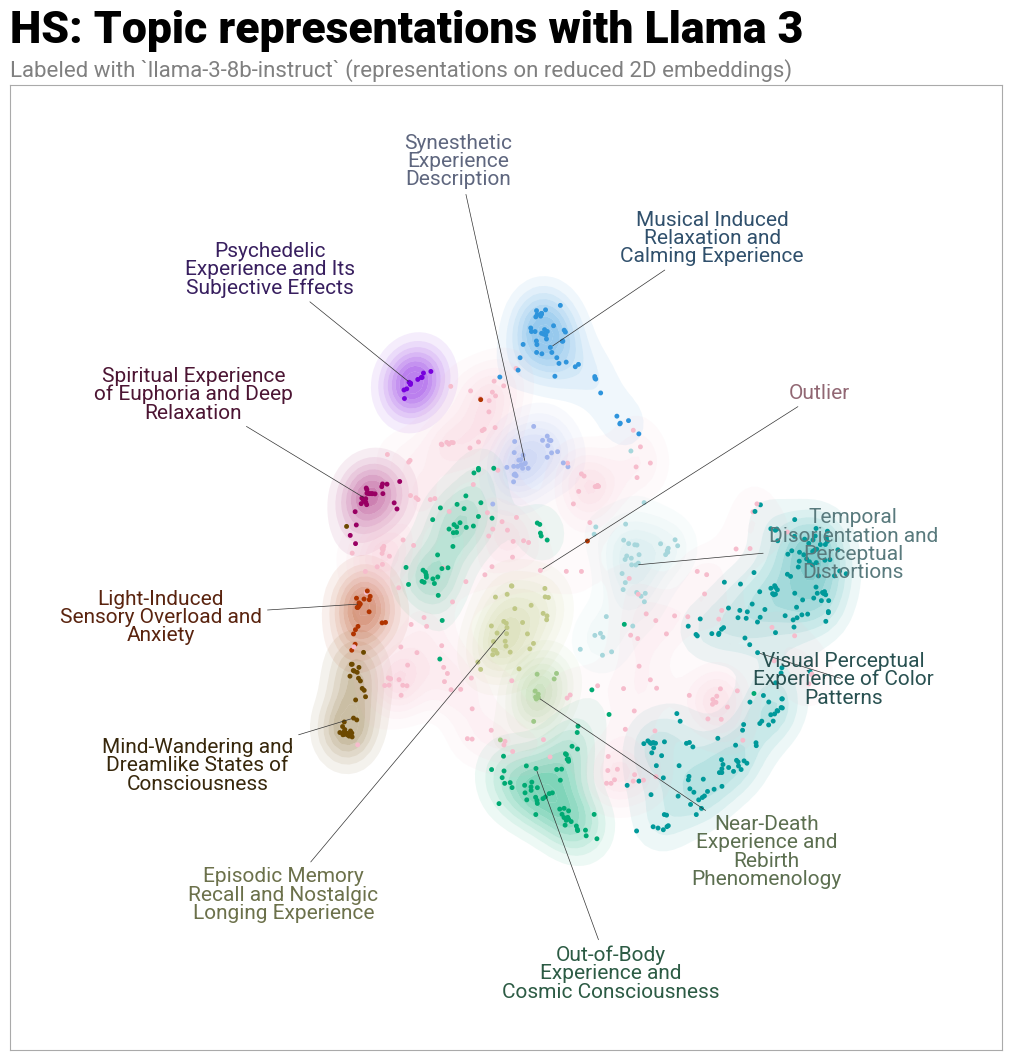

In [34]:
# Basic visu (to compare with visu before LLM labelling)
display(topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True))


# Datammaplot visu 
reduced_embeddings = UMAP(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=2, #reduced embedding to 2D for visualization
    min_dist=float(chosen_params['min_dist']),
    metric='cosine',
    random_state=random_seed
).fit_transform(embeddings)

datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title=f"{condition}: Topic representations with Llama 3",
   sub_title="Labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
)

# hierarchical visu
display(topic_model.visualize_hierarchy(custom_labels=True))

### create and save final topic summary

In [ ]:
def create_topic_summary(topic_labels, df_reports, topics):
    """Creates df summarizing topic counts and content."""
    topic_analysis = pd.DataFrame({
        'Topic_Content': df_reports,
        'Topic_Number': topics
    })
    
    # map the topic number to the generated Llama label
    topic_analysis['Topic_Label'] = topic_analysis['Topic_Number'].map(topic_labels).fillna("Outlier")

    # Group and aggregate results
    topic_summary = (
        topic_analysis
        .groupby(['Topic_Label', 'Topic_Number'])
        .agg(
            Sentence_Count=('Topic_Content', 'count'),
            Content=('Topic_Content', list)
        )
        .sort_values('Sentence_Count', ascending=False)
        .reset_index()
    )
    
    return topic_summary

# --- Generate and display the summary ---
topic_summary = create_topic_summary(topic_labels, df_reports, topics)

print("\nFinal Topic Summary:")
print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])

# --- Save summary to CSV ---
summary_results_file = os.path.join(project_root, "RESULTS", f"topic_analysis_{condition}.csv")
topic_summary.to_csv(summary_results_file, index=False)
print(f"\nSummary saved to {summary_results_file}")
